In [50]:
# 2. Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [51]:
# 3. Dataset setup
dataset_path = "./Recycle Dataset"

# Update these lists to exactly match folder names inside 'recyclable/' and 'non_recyclable/'
recyclable_classes = [
    'recyclable/alluminium',
    'recyclable/cardboard',
    'recyclable/glass',
    'recyclable/paper',
    'recyclable/plastic'
]

non_recyclable_classes = [
    'non_recyclable/diaper',
    'non_recyclable/organic_waste',
    'non_recyclable/pizza_box',
    'non_recyclable/styrofoam',
    'non_recyclable/tissue'
]

# Merge lists into one class list
class_names = recyclable_classes + non_recyclable_classes

IMG_SIZE = 224
data, labels = [], []


In [52]:
# 4. Load images using PIL (reliable color-loading)
from PIL import Image
import numpy as np
from tensorflow.keras.utils import to_categorical
import os

for idx, cat in enumerate(class_names):
    folder = os.path.join(dataset_path, cat)
    if not os.path.exists(folder):
        print(f"⚠️ Skipping missing folder: {folder}")
        continue

    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        try:
            img = Image.open(fpath).convert('RGB')
            img = img.resize((IMG_SIZE, IMG_SIZE))
            data.append(np.array(img))
            labels.append(idx)
        except Exception as e:
            print(f"Skipped: {fpath} ({e})")

# Convert to NumPy arrays and normalize
data = np.array(data, dtype=np.float32) / 255.0
labels = to_categorical(np.array(labels), num_classes=len(class_names))

print(f"✅ Loaded {data.shape[0]} images. Input shape: {data.shape[1:]}")



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Skipped: ./Recycle Dataset/recyclable/cardboard/.DS_Store (cannot identify image file './Recycle Dataset/recyclable/cardboard/.DS_Store')
✅ Loaded 5518 images. Input shape: (224, 224, 3)


In [53]:
# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)
print("Train:", len(X_train), "Test:", len(X_test))


Train: 4414 Test: 1104


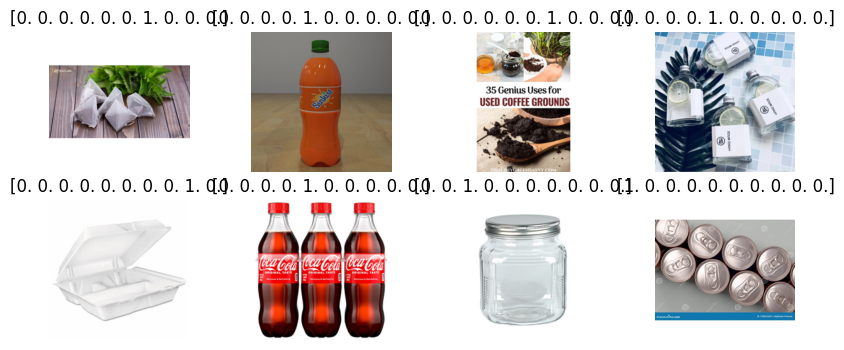

In [54]:
# 6. Show some actual images (sanity check)
plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

In [55]:
# 7. Augmentation setup (no rescale here)
datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True,
    fill_mode='nearest', validation_split=0.2)

train_gen = datagen.flow(X_train, y_train, batch_size=32, subset='training')
val_gen   = datagen.flow(X_train, y_train, batch_size=32, subset='validation')

Aug batch shape: (32, 224, 224, 3) min,max: 0.0 1.0


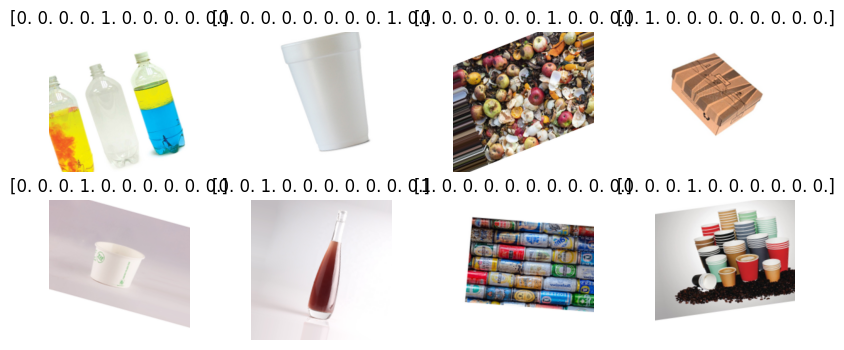

In [56]:
# 8. Check visualization of augmented images
sample_images, sample_labels = next(train_gen)
print("Aug batch shape:", sample_images.shape, "min,max:", sample_images.min(), sample_images.max())
plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(sample_images[i])
    plt.title(sample_labels[i])
    plt.axis('off')
plt.show()


In [57]:
# Step 9: Build Transfer Learning model using MobileNetV2 (local weights, 224x224)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

num_classes = len(class_names)  # keep from your setup
IMG_SIZE = 224                 # must match your generators and weights file

# If your generators ALREADY use preprocessing_function=preprocess_input, set this to False
ADD_PREPROCESS_LAYER = False

# Base model with local weights (no top)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"
)
base_model.trainable = False  # freeze backbone

# Build head
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# (Optional) apply MobileNetV2 preprocessing here if your generators did NOT
x = layers.Lambda(preprocess_input, name="mnetv2_preprocess")(inputs) if ADD_PREPROCESS_LAYER else inputs

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [58]:
# Step 10: Train model with callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.4004 - loss: 1.8545
Epoch 1: val_accuracy improved from None to 0.68027, saving model to best_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 27s 226ms/step - accuracy: 0.5294 - loss: 1.4230 - val_accuracy: 0.6803 - val_loss: 0.9078 - learning_rate: 0.0010
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6840 - loss: 0.9129
Epoch 2: val_accuracy improved from 0.68027 to 0.73469, saving model to best_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 0.6922 - loss: 0.8882 - val_accuracy: 0.7347 - val_loss: 0.7675 - learning_rate: 0.0010
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7097 - loss: 0.8187
Epoch 3: val_accuracy improved from 0.73469 to 0.76304, saving model to best_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 235ms/step - accuracy: 0.7223 - loss: 0.7877 - val_accuracy: 0.7630 - val_loss: 0.6986 - learning_rate: 0.0010
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/st

In [59]:
# 11. Evaluate on hold-out test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("Test accuracy:", test_acc)


35/35 - 9s - 253ms/step - accuracy: 0.8243 - loss: 0.4953
Test accuracy: 0.8242753744125366


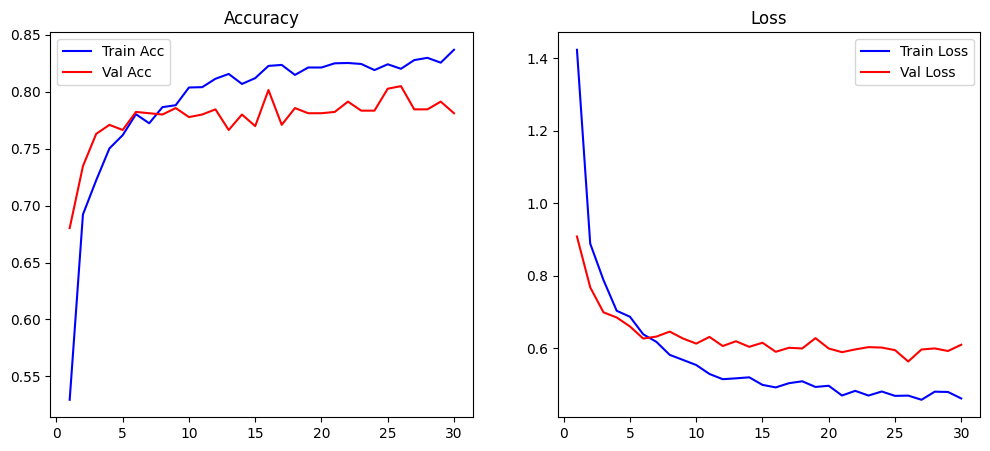

In [60]:
# 12. Plot training curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Train Acc')
plt.plot(epochs, val_acc, 'r-', label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()


In [61]:
# 13. Save model (optional)
model.save("recycle_classifier.h5")


In [62]:
# 14. Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

with open("recycle_classifier.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model saved and converted to TFLite in current folder.")



INFO:tensorflow:Assets written to: /var/folders/1b/m4m114l97_9bbvtjk1l1rd0h0000gn/T/tmpqcq7xr_x/assets


INFO:tensorflow:Assets written to: /var/folders/1b/m4m114l97_9bbvtjk1l1rd0h0000gn/T/tmpqcq7xr_x/assets


Saved artifact at '/var/folders/1b/m4m114l97_9bbvtjk1l1rd0h0000gn/T/tmpqcq7xr_x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1496')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  13184053136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13184054864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13184051408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13184051216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13184053328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13184052944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13184049296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13184050640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13184049104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13184053520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1318

W0000 00:00:1754441529.475878 1225743 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1754441529.476121 1225743 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-06 03:52:09.476516: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/1b/m4m114l97_9bbvtjk1l1rd0h0000gn/T/tmpqcq7xr_x
2025-08-06 03:52:09.481179: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-06 03:52:09.481186: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/1b/m4m114l97_9bbvtjk1l1rd0h0000gn/T/tmpqcq7xr_x
2025-08-06 03:52:09.541847: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-06 03:52:09.854571: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/1b/m4m114l97_9bbvtjk1l1rd0h0000gn/T/tmpqcq7xr_x
2025-08-06 03:52:09.941550: I tensorflow/cc/saved_model/loader.cc: